In [97]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [98]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


I did not find this trivial, so here is the exact derivation of the gradient.

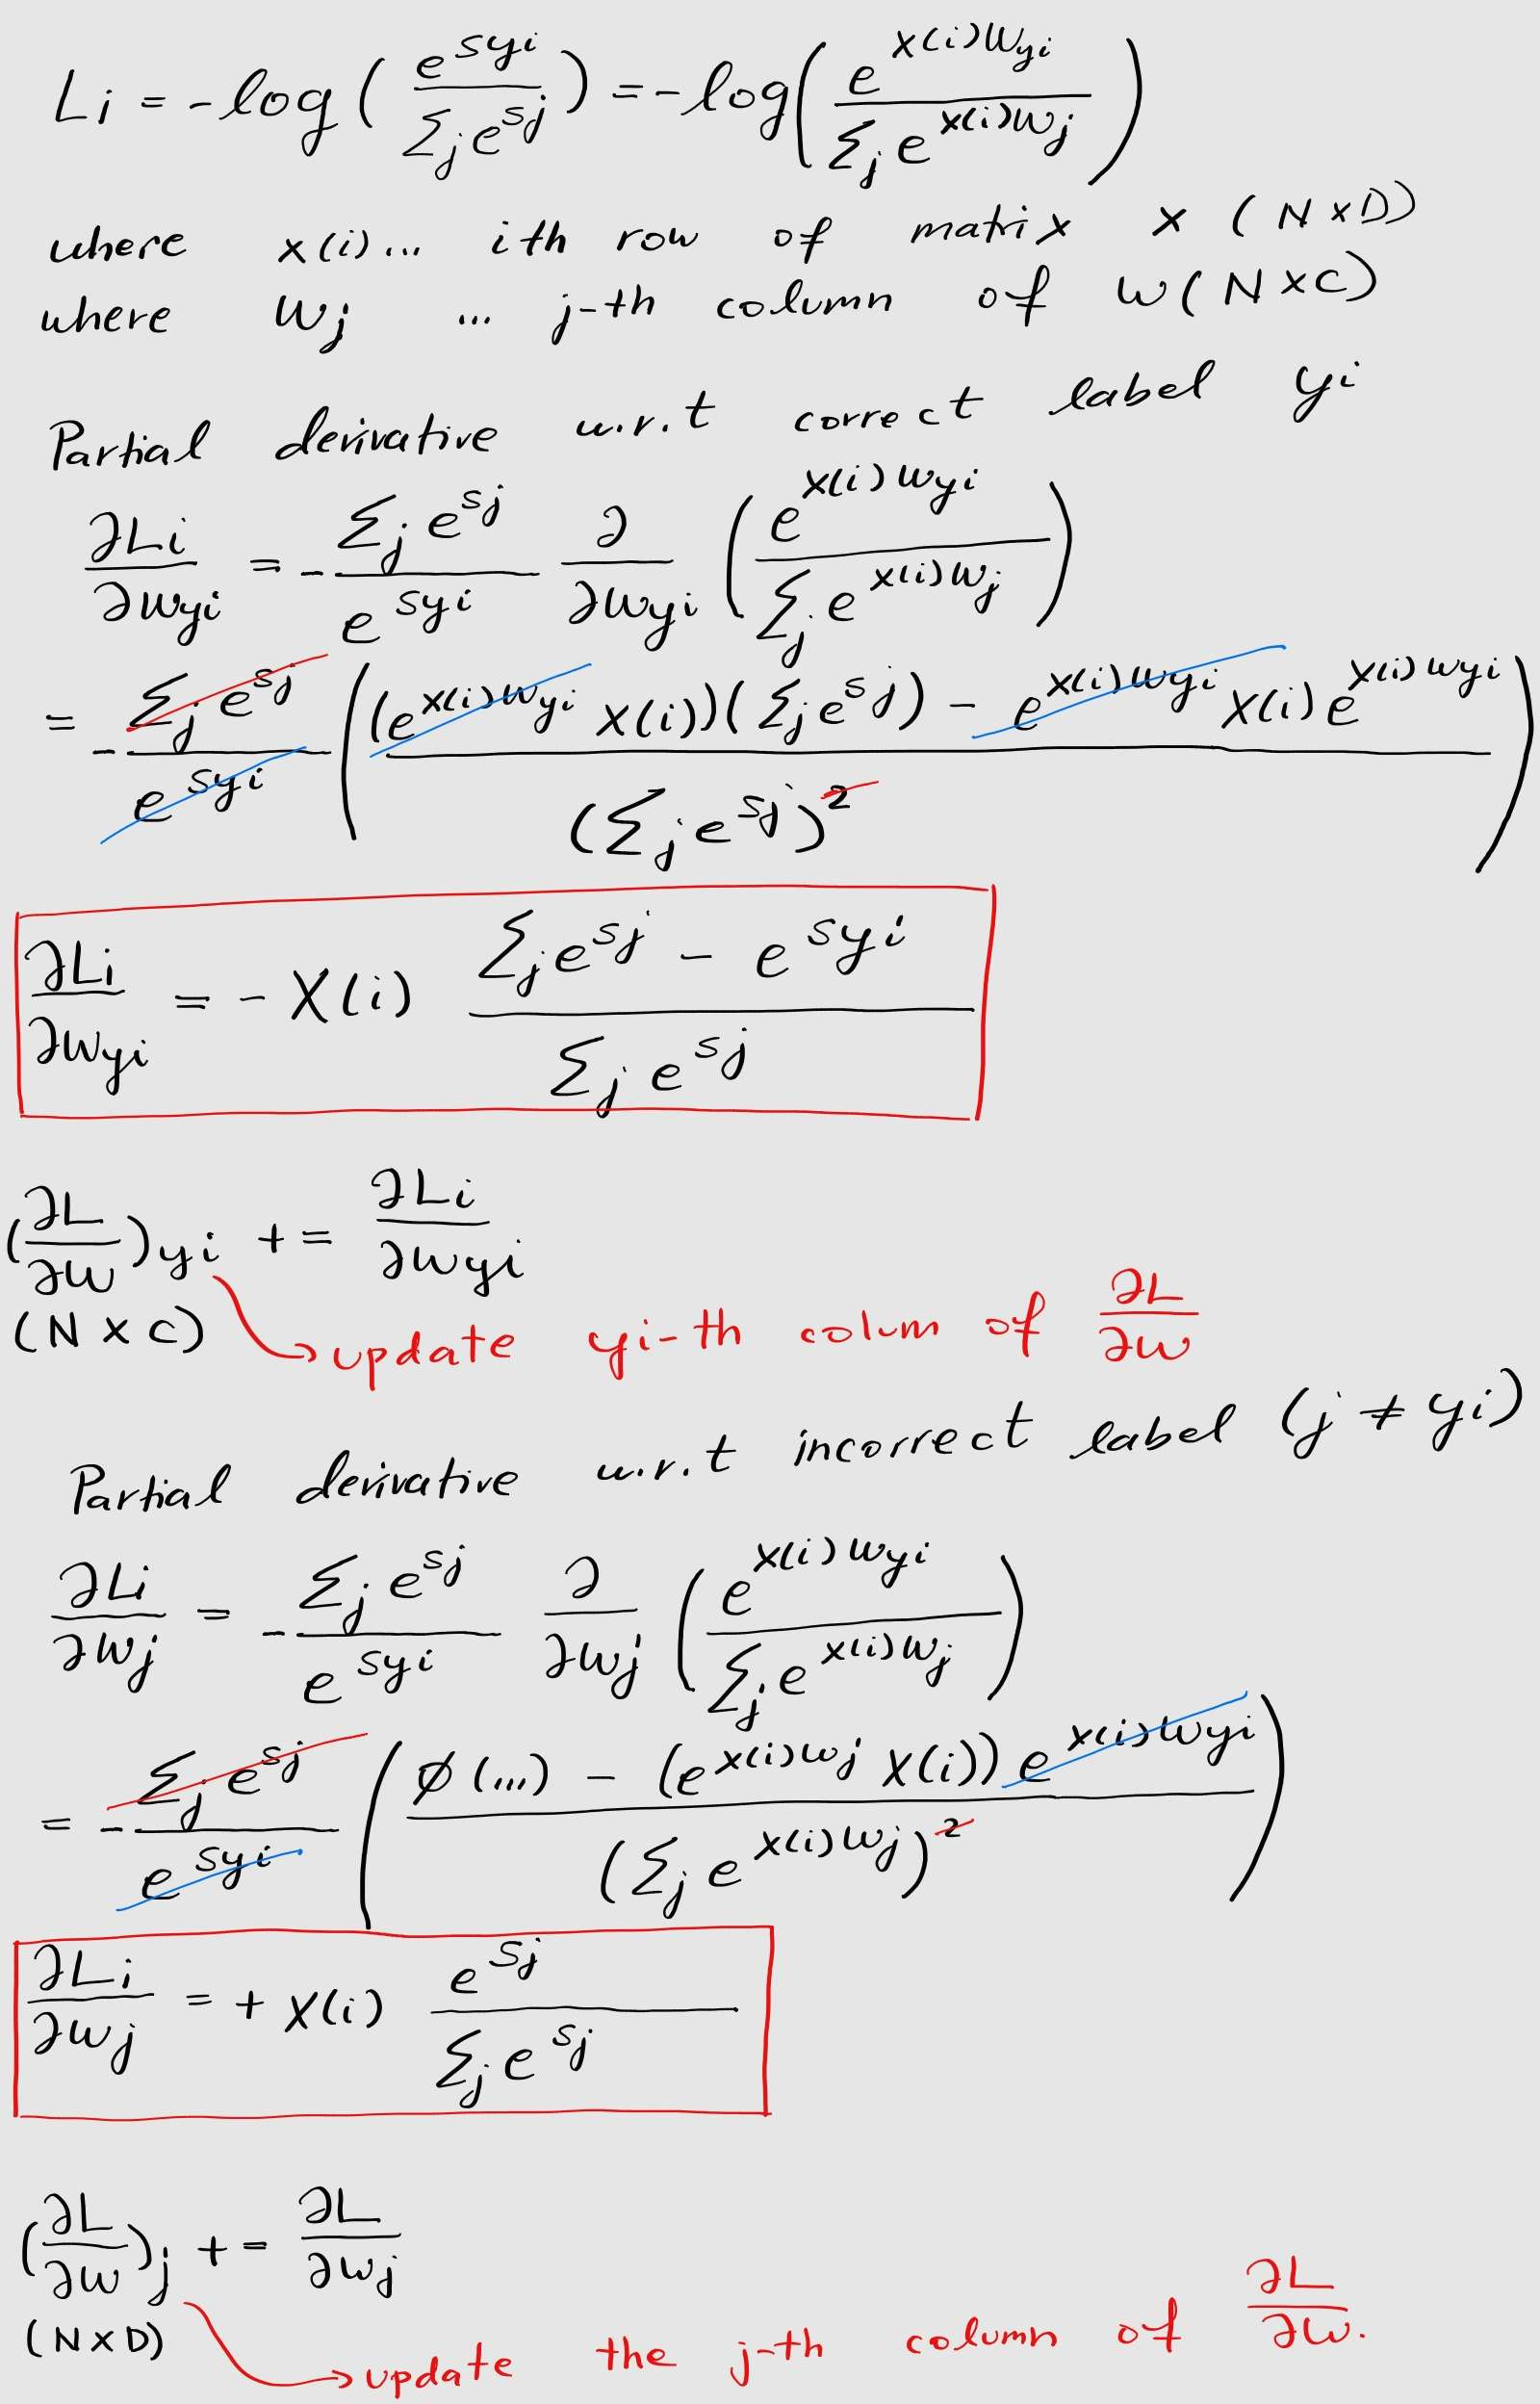

In [101]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.335257
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *We initialize the weight of the model $W$ to be rough equal to zero. therefore the softmax loss boiles down to $- \log({\frac{1}{\#\text{classes}}})$. If we initialize the weights to 0, we actually get exactly the same result.$* 



In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.746757 analytic: -0.746757, relative error: 7.237008e-08
numerical: 3.363771 analytic: 3.363771, relative error: 2.002617e-08
numerical: -1.859369 analytic: -1.859369, relative error: 1.648009e-08
numerical: 1.398408 analytic: 1.398408, relative error: 5.002011e-09
numerical: -1.045570 analytic: -1.045570, relative error: 3.010719e-08
numerical: -0.781587 analytic: -0.781588, relative error: 8.748169e-08
numerical: -1.745004 analytic: -1.745005, relative error: 4.166250e-08
numerical: 0.467948 analytic: 0.467948, relative error: 7.752538e-08
numerical: -1.028246 analytic: -1.028246, relative error: 2.106219e-08
numerical: 0.251238 analytic: 0.251238, relative error: 3.026548e-07
numerical: 1.540624 analytic: 1.540624, relative error: 9.480966e-09
numerical: 2.421490 analytic: 2.421490, relative error: 9.096708e-09
numerical: 1.148493 analytic: 1.148493, relative error: 5.641308e-08
numerical: 4.269169 analytic: 4.269169, relative error: 1.374860e-08
numerical: 3.405674 an

In [104]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.335257e+00 computed in 0.121015s
vectorized loss: 2.335257e+00 computed in 0.039567s
Loss difference: 0.000000
Gradient difference: 123.305924


In [105]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.228157 analytic: -2.228157, relative error: 1.606532e-08
numerical: -2.306548 analytic: -2.306548, relative error: 2.066926e-08
numerical: 1.562916 analytic: 1.562916, relative error: 1.748442e-08
numerical: -0.184376 analytic: -0.184376, relative error: 2.516048e-07
numerical: 1.502077 analytic: 1.502077, relative error: 5.718818e-08
numerical: -1.954731 analytic: -1.954732, relative error: 2.346154e-08
numerical: -1.883472 analytic: -1.883472, relative error: 2.407460e-09
numerical: 0.878274 analytic: 0.878274, relative error: 9.621175e-08
numerical: 0.266260 analytic: 0.266260, relative error: 1.796301e-07
numerical: -1.896505 analytic: -1.896505, relative error: 1.775893e-08
numerical: 1.020511 analytic: 1.020511, relative error: 4.806918e-08
numerical: 3.346457 analytic: 3.346457, relative error: 3.276912e-08
numerical: -1.844671 analytic: -1.844671, relative error: 9.897664e-09
numerical: -1.242391 analytic: -1.242391, relative error: 2.345623e-08
numerical: 0.27685

In [106]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [5e2, 1e3, 1e4, 5e4]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools
from tqdm import tqdm

for param in tqdm(list(itertools.product(learning_rates, regularization_strengths))):
    learning_rate, reg = param

    # Traing the linear classifier on the training set
    softmax = Softmax()
    _ = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                        num_iters=1500, verbose=False)
    
    y_train_pred = softmax.predict(X_train)
    acc_train = np.mean(y_train == y_train_pred)

    # Test the linear classifier on the validation set
    y_val_pred = softmax.predict(X_val)
    acc_val = np.mean(y_val == y_val_pred)

    # Store performance
    results[(learning_rate, reg)] = (acc_train, acc_val)
    if acc_val > best_val:
        best_val = acc_val
        best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

100%|██████████| 16/16 [03:20<00:00, 12.54s/it]

lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.327755 val accuracy: 0.342000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.324980 val accuracy: 0.341000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.330020 val accuracy: 0.342000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.325571 val accuracy: 0.333000
lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.324449 val accuracy: 0.338000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.324857 val accuracy: 0.346000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.328469 val accuracy: 0.343000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.327061 val accuracy: 0.337000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.325082 val accuracy: 0.342000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.326653 val accuracy: 0.336000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.328184 val accuracy: 0.341000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.326347 val accuracy: 0.349000
lr 1.000000e-06 reg 5.000000

In [107]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.341000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ Yes.


$\color{blue}{\textit Your Explanation:}$ *If we add a new datapoint, for which the predicted score of the correct label is larger (by atleast the specified margin, e.g margin=1) than incorrect labels score, the svm loss won't increase, whereas the softmax loss will increase).Example of this behaviour is shown bellow.*



SVM vs Softmax loss

In [124]:
scores = np.array([0.99, 0.01])
loss_i = -np.log(np.exp(scores[0]) / (np.exp(scores[0]) + np.exp(scores[1])))
print(f"softmax loss: {loss_i}")

# if the margin is met, i.e (correct_score - incorrect_score) >= 1
svm_scores = np.array([2, 1])
loss_i = max(0, svm_scores[1] - svm_scores[0] + 1)
print(f"svm loss: {loss_i}")

svm_scores = np.array([10, 1])
loss_i = max(0, svm_scores[1] - svm_scores[0] + 1)
print(f"svm loss: {loss_i}")

# if the margin is met than svm behaves the same as softmax
svm_scores = np.array([2, 1.1])
loss_i = max(0, svm_scores[1] - svm_scores[0] + 1)
print(f"svm loss: {loss_i}")

softmax loss: 0.3186799592371327
svm loss: 0
svm loss: 0
svm loss: 0.10000000000000009


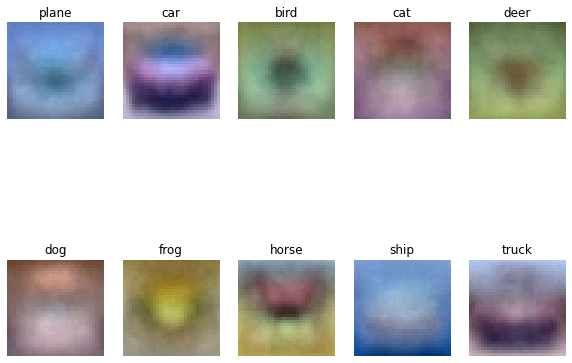

In [108]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])